In [ ]:
'''
Created on 2026. 1. 24.

@author: chaliepark
'''
import pandas as pd
from os.path import join
from sklearn.model_selection import train_test_split,GridSearchCV as tv,KFold,cross_val_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

#테스트데이터 6368개만나오게 하기위함
T_DATA_E_INDEX=-87

DATA_DIR='~/work/kaggle_kakr_housing/data'
#그리드서치CV를 하고 애 버리지ㅇㅇ블랜딩.한다.

def save_submission(models, train, y, test, model_name, rmsle=None,data_dir = DATA_DIR):
    pdt, o_list = AveragingBlending(models,train,y,test)
    
    #prediction = np.expm1(prediction)
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)[:T_DATA_E_INDEX]
    submission['price'] = pdt
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    return o_list

def AveragingBlending(models, x, y, sub_x):
    g_list=[]
    for m in models:
        print(m['name'])
        m['model'].fit(x.values,y.values)

    predictions = np.column_stack([m['model'].predict(sub_x.values) for m in models])
    
    for m in models:
        # 결과값 저장
        params = m['model'].cv_results_['params']
        score = m['model'].cv_results_['mean_test_score']
    
        # 데이터 프레임 생성ß
        results = pd.DataFrame(params)
        results['score'] = score
    
        # RMSLE 값 계산 후 정렬
        results['RMSLE'] = np.sqrt(-1 * results['score'])
        results = results.sort_values('RMSLE')
        g_list.append(results)
    return np.mean(predictions, axis=1),g_list



def my_GridSearch(models, train, y, test, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    #count=0
    for mo in models:
        mo['model'] = tv(mo['model'], param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
        #count += 1

    # 모델 fitting
    #grid_model.fit(train, y)
    o_list = save_submission(models, train, y, test, 'lgbm', rmsle='0.164399')
    
    

    return o_list




train_df = pd.read_csv(join(DATA_DIR,'train.csv'))
test_df = pd.read_csv(join(DATA_DIR,'test.csv'))




##train의 max id의 다음 값이test의 max id가 되게 맞춰줌
max_train_id=train_df["id"].max()
test_df['id']=[t for t in range(max_train_id+1,max_train_id+1+len(test_df['id']))]

## 
y=train_df['price']
del train_df['price']

data= pd.concat((train_df,test_df),axis=0)
data.info()

data['date'] = data['date'].apply(lambda t: str(t[:6]))


train_len = len(train_df)


print('');X = data[:train_len];test=data[train_len:T_DATA_E_INDEX]
del data['id']


#np.expm1()


'''
#데이터분석을 위한소스코드 
fig, ax = plt.subplots(5,4,figsize=(20, 8))
count=0
columns1=data.columns

for row in range(5):
    for col in range(4):
        if count != 1:
            sns.kdeplot(data=data[columns1[count]], ax=ax[row][col])
            ax[row][col].set_title(columns1[count], fontsize=15)
        count += 1
        if count == 19 :
            break
'''




columns =['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
## 꼬인데이터에 로그연산 
for i in columns:
    data[i]=np.log1p(data[i].values)
'''
#데이터분석을 위한소스코드 
fig, ax = plt.subplots(2, 3,figsize=(15, 5))

count=0
for row in range(2):
    for col in range(3):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
'''


## 차원을 높이는게? 

##plt.show()



#(train_X,train_y,test_X,test_y) = train_test_split(X,y,random_state=42,test_size=0.2)

param_grid={
    'n_estimators': [ 80, 100, 110,120, 130],
    'max_depth': [ 3, 5,6,7, 8, 10]
}

gboost = GradientBoostingRegressor(learning_rate= 0.5,random_state=2019)
xgboost = xgb.XGBRegressor(learning_rate= 0.5,random_state=2019)
lightgbm = LGBMRegressor(learning_rate= 0.5,random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


o_list = my_GridSearch(models,X,y,test,param_grid,verbose=2,n_jobs=5)

count=0
for o in o_list:
    print(models[count]['name'])
    print(o)
    count += 1









<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_living1

#결과캡처
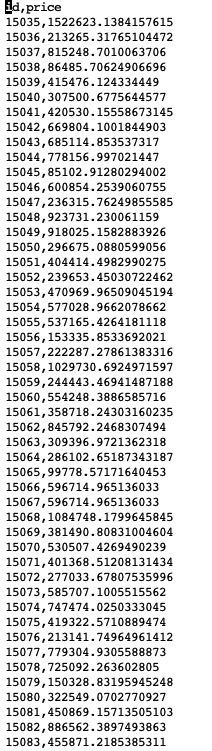